In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
from datetime import datetime
from IPython.display import HTML
from matplotlib import animation

# Ignore some warnings produced by basemap
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# try to import Basemap
try:
    from mpl_toolkits.basemap import Basemap
    has_basemap = True
except ImportError:
    has_basemap = False

# Set the map resolution
# Notice: set resolution to full will make this program time-consuming
map_resolution = "i" # l: low, i: intermediate, h: high, f: full
    
plt.rcParams['figure.figsize'] = (20,5) # fiqure size

# Dataset
PM2.5 Dataset，every data has the following attributes: 
    - PM25: PM2.5 濃度
    - PM10: PM10 濃度
    - PM1 : PM1 濃度
    - Humidity: 溼度
    - Temperature: 溫度
    - DateTime: 時間
    - device_id: 感測器 id
    - record_id: 資料記錄 id
    - lon, lat: 感測器座標

In [2]:
with open('PM2.5.csv', mode='r', encoding='utf-8') as file:
    pm25_data = pd.read_csv(file, parse_dates=['DateTime'])

pm25_data.head()

,record_id,device_id,DateTime,PM25,PM10,PM1,Temperature,Humidity,lat,lon
0,12773,28C2DDDD415C,2017-03-01 08:30:00,43,0,0,19.61,96,23.741,120.755
1,12774,28C2DDDD415C,2017-03-01 09:00:00,41,0,0,19.81,94,23.741,120.755
2,12775,28C2DDDD415C,2017-03-01 09:30:00,41,0,0,19.73,93,23.741,120.755
3,12776,28C2DDDD415C,2017-03-01 10:00:00,47,0,0,19.17,92,23.741,120.755
4,12777,28C2DDDD415C,2017-03-01 10:30:00,50,0,0,19.90,91,23.741,120.755


 ## Problem Definition
    Use the concentration of PM2.5 in every 30 minutes of the whole days of time(00:00 - 23:30) in March(one device id with 1488 dimensions features) to see whether the concentration of PM2.5 along the time has any correlation with the location of these devices.

## Data Preprocessing (PM2.5)
    1. Remove the non-numerical PM2.5 data.
    2. Extract the column of PM2.5, and combine with time that is from 00:00 to 23:30 with 30 minutes interval.

In [3]:
def IsNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

#Remove non-numerical data
truncate_list = [x for x in pm25_data.index if(not IsNumber(pm25_data['PM25'][x]))]
for x in truncate_list:
    pm25_data.drop(x)

In [4]:
pm25_data_group_deviceid = pm25_data.groupby('device_id').count()
pm25_data_time_series = pd.DataFrame(0, index=pm25_data_group_deviceid.index, columns=['time'])
pm25_data_time_series = pd.concat([pm25_data_time_series]*48*31)
pm25_data_time_series.sort_index(inplace=True)
pm25_data_time_series['time'] = np.tile(pd.date_range("2017-03-01 00:00", "2017-03-31 23:30", freq="30min"), len(pm25_data_group_deviceid))

print(f"===> {type(pm25_data_time_series)}")
pm25_data_time_series.head()

===> <class 'pandas.core.frame.DataFrame'>


,time
device_id,
28C2DDDD415C,2017-03-01 00:00:00
28C2DDDD415C,2017-03-01 00:30:00
28C2DDDD415C,2017-03-01 01:00:00
28C2DDDD415C,2017-03-01 01:30:00
28C2DDDD415C,2017-03-01 02:00:00


In [5]:
pm25_data_drop = pm25_data[['device_id', 'DateTime', 'PM25']].drop_duplicates()
pm25_time_slot = pm25_data_drop.groupby(['device_id', pd.Grouper(key='DateTime', freq='30Min')]).mean()
pm25_time_slot.reset_index(inplace=True)
pm25_time_slot.columns = ['device_id', 'time', 'PM25']
pm25_time_slot.head()

,device_id,time,PM25
0,28C2DDDD415C,2017-03-01 08:30:00,43
1,28C2DDDD415C,2017-03-01 09:00:00,41
2,28C2DDDD415C,2017-03-01 09:30:00,41
3,28C2DDDD415C,2017-03-01 10:00:00,47
4,28C2DDDD415C,2017-03-01 10:30:00,50


In [6]:
pm25_data_time_series.reset_index(inplace=True)
pm25_data_time_series = pd.merge(pm25_data_time_series, pm25_time_slot, how = 'left', on=['device_id', 'time'])
pm25_data_time_series.fillna(0, inplace=True)
pm25_data_time_series.set_index('device_id', inplace=True)
pm25_data_time_series.head(20)

,time,PM25
device_id,,
28C2DDDD415C,2017-03-01 00:00:00,0.0
28C2DDDD415C,2017-03-01 00:30:00,0.0
28C2DDDD415C,2017-03-01 01:00:00,0.0
28C2DDDD415C,2017-03-01 01:30:00,0.0
28C2DDDD415C,2017-03-01 02:00:00,0.0
28C2DDDD415C,2017-03-01 02:30:00,0.0
28C2DDDD415C,2017-03-01 03:00:00,0.0
28C2DDDD415C,2017-03-01 03:30:00,0.0
28C2DDDD415C,2017-03-01 04:00:00,0.0


In [7]:
weekflow_pd = pm25_data_time_series.loc[(pm25_data_time_series['time'] >= datetime(2017, 3, 1)) & (pm25_data_time_series['time'] <= datetime(2017, 3, 31)), ['PM25']]
weekflow = weekflow_pd.groupby(weekflow_pd.index).aggregate(lambda x: list(x)).sum(axis=1)
print(weekflow.head(5))
print(f"==>type(weekflow) = {type(weekflow)}")
weekflow = weekflow.tolist()

device_id
28C2DDDD415C    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
28C2DDDD415F    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
28C2DDDD423C    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
28C2DDDD42C7    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
28C2DDDD42F7    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dtype: object
==>type(weekflow) = <class 'pandas.core.series.Series'>


# Temperal PM2.5 Clustering(KMeans)

### Silhouette method
    To determine what value of k(cluster number) will get good performance.

k = 2, score = 0.30171972384077816
k = 3, score = 0.2226896581090295
k = 4, score = 0.23712210143208062
k = 5, score = 0.19056616849550803
k = 6, score = 0.17425665809854524
k = 7, score = 0.16232122979875682
k = 8, score = 0.16159512408067817
k = 9, score = 0.18061026580904097
k = 10, score = 0.17106952850354346
k = 11, score = 0.16091300588540852
k = 12, score = 0.17210147814628524
k = 13, score = 0.14870251020261394
k = 14, score = 0.1573195731804122
k = 15, score = 0.15106116000689196


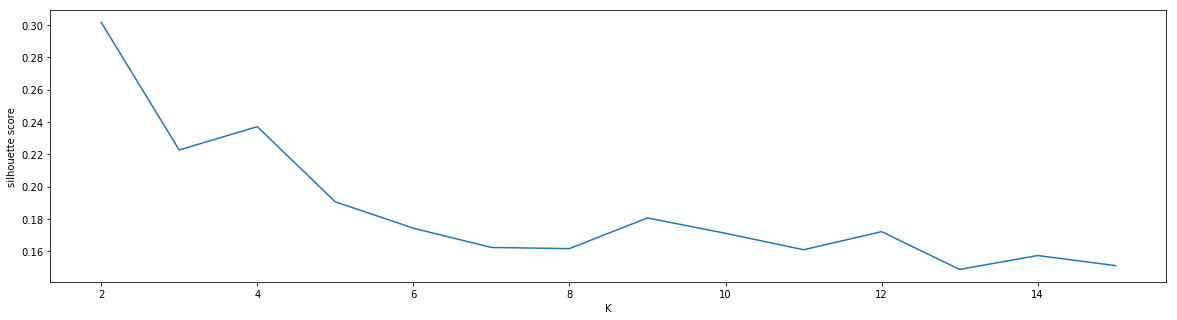

In [8]:
pm25_data_group_deviceid_pos = pm25_data.groupby('device_id').mean()
coords = pm25_data_group_deviceid_pos.as_matrix(columns=['lat', 'lon'])
x, y = coords[:, 1], coords[:, 0]

maxK = 16
score = []

for k in range(2, maxK):
    kmeans = KMeans(n_clusters=k).fit(weekflow)
    score.append(metrics.silhouette_score(weekflow, kmeans.labels_))
    print(f'k = {k}, score = {score[-1]}')
    
fig = plt.figure(figsize=(20,5))
plt.xlabel('K')
plt.ylabel('silhouette score')
plt.plot(range(2, maxK), score)
plt.show()


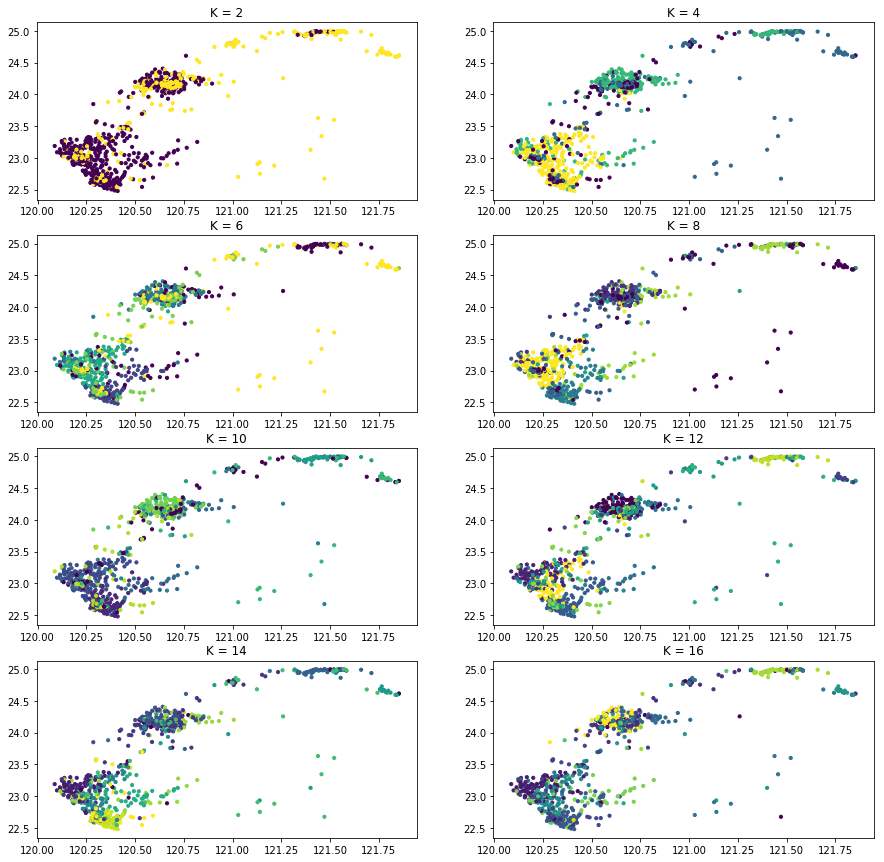

In [9]:
maxK = 16
fig = plt.figure(figsize=(15,15))
for i in range(2, 8 + 9, 2):
    plt.subplot(4, 2, int(i / 2))
    #draw_map()
    plt.title('K = ' + str(i))
    kmeans = KMeans(n_clusters=i).fit(weekflow)
    plt.scatter(x, y, c=kmeans.labels_, zorder=3, s=10)

### Comment
    Silhouette method illustrates that the clustering performance will be the best when K = 2. So we choose K = 2 to plot the result as below.

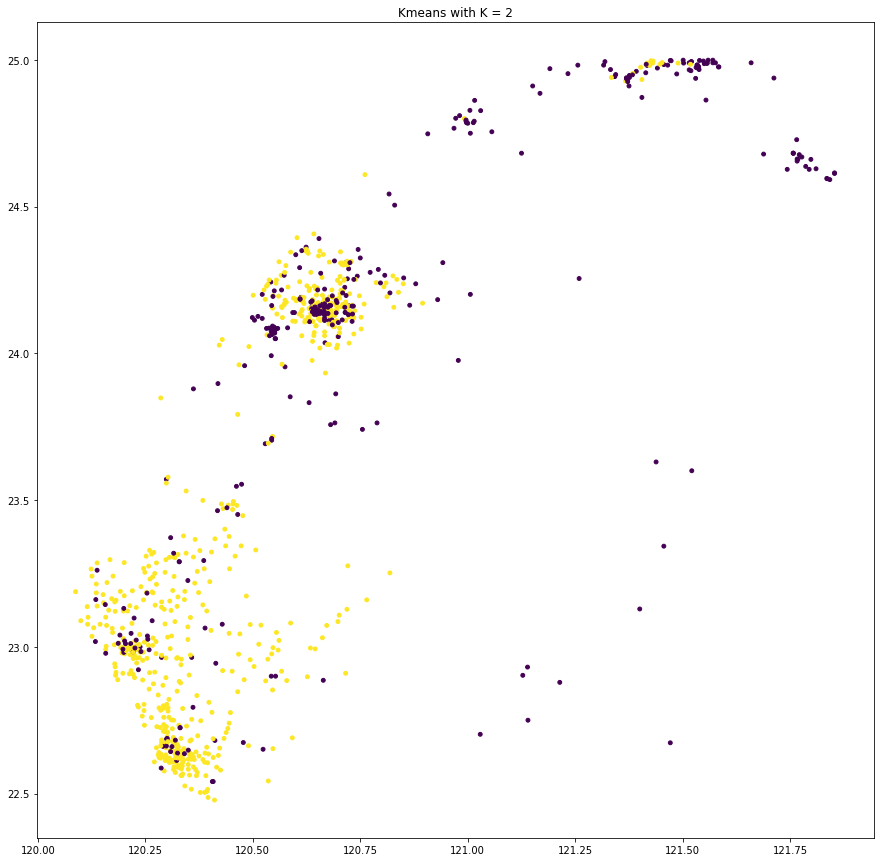

In [10]:
kmeans = KMeans(n_clusters=2).fit(weekflow)
fig = plt.figure(figsize=(15, 15))
plt.scatter(x, y, c=kmeans.labels_, s=15, zorder=3)

plt.title('Kmeans with K = ' + str(2))
plt.show()

# Temperal PM2.5 Clustering(Hierarchical Clustering, Agglomerative)

### Silhouette method
    To determine what value of k(cluster number) will get good performance.

k = 2, score = 0.3239454856276273
k = 3, score = 0.3249397940361311
k = 4, score = 0.3266970538504648
k = 5, score = 0.3093446587399293
k = 6, score = 0.24054735926974957
k = 7, score = 0.23523521824347637
k = 8, score = 0.21844807942378267
k = 9, score = 0.21901352564547033
k = 10, score = 0.21933720561638761
k = 11, score = 0.21289874676282047
k = 12, score = 0.20463782764879979
k = 13, score = 0.1937888241413741
k = 14, score = 0.1894672463047159
k = 15, score = 0.12248332615954298


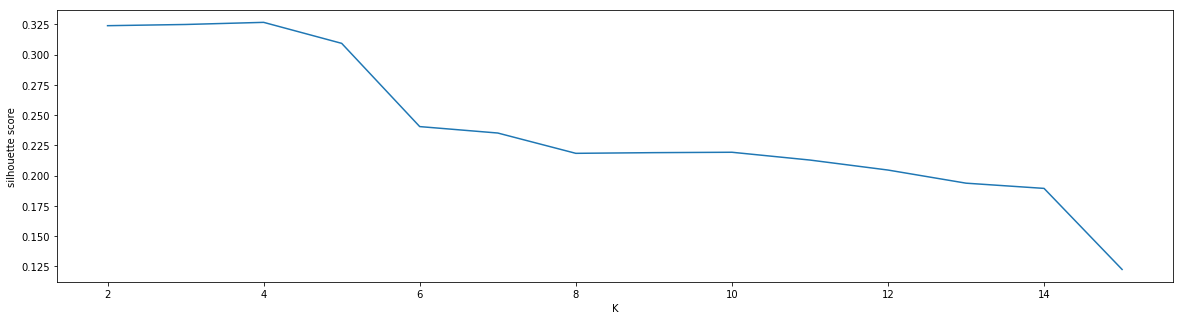

In [11]:
maxK = 16
score = []

for k in range(2, maxK):
    #kmeans = KMeans(n_clusters=k).fit(weekflow)
    model = AgglomerativeClustering(n_clusters=k, affinity='manhattan', linkage="complete").fit(weekflow)
    score.append(metrics.silhouette_score(weekflow, model.labels_))
    print(f'k = {k}, score = {score[-1]}')
    
fig = plt.figure(figsize=(20,5))
plt.xlabel('K')
plt.ylabel('silhouette score')
plt.plot(range(2, maxK), score)
plt.show()

In [12]:
def agg_cluster(n_clusters):
    fig = plt.figure(figsize=(15, 15))
    for index, metric in enumerate(["euclidean", "manhattan"]):
        model = AgglomerativeClustering(n_clusters=n_clusters, affinity=metric, linkage="complete").fit(weekflow)
        plt.subplot(1,2,index+1)
        #draw_map()
        plt.title("affinity = %s" % metric, size=20)
        plt.scatter(x, y, c=model.labels_, s=15, zorder=3)
    plt.suptitle("clustering number: %d" % n_clusters, size=20)
    plt.show()

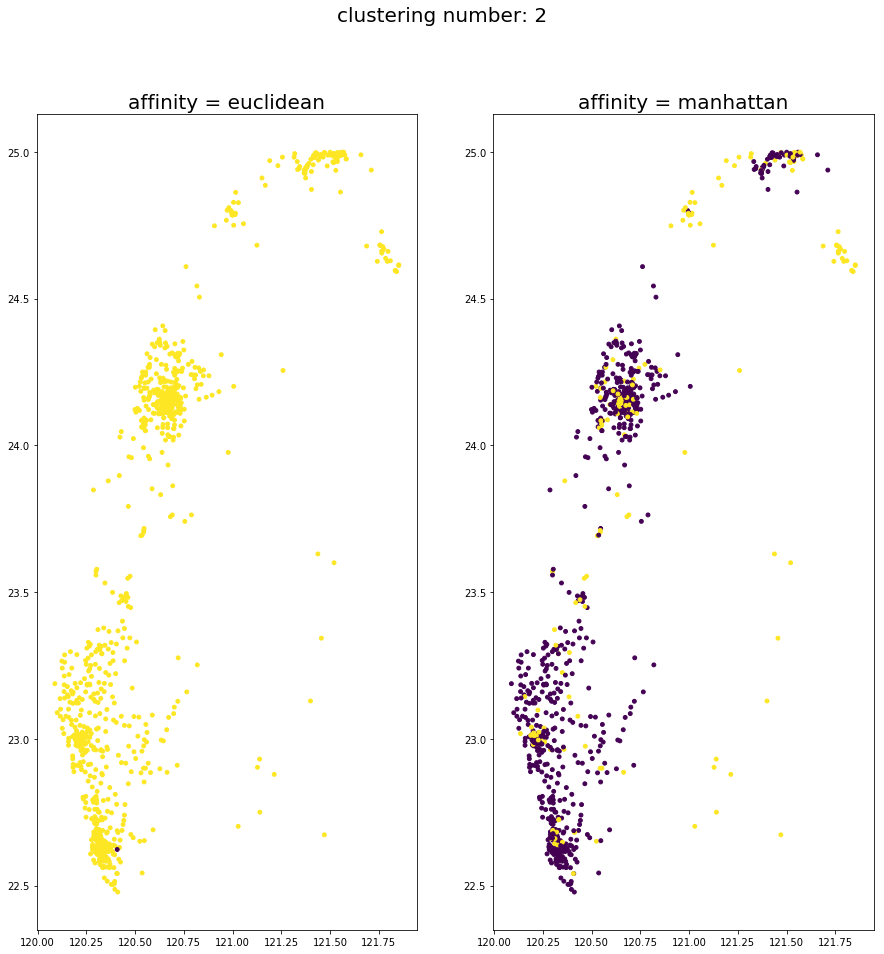

In [13]:
agg_cluster(2)

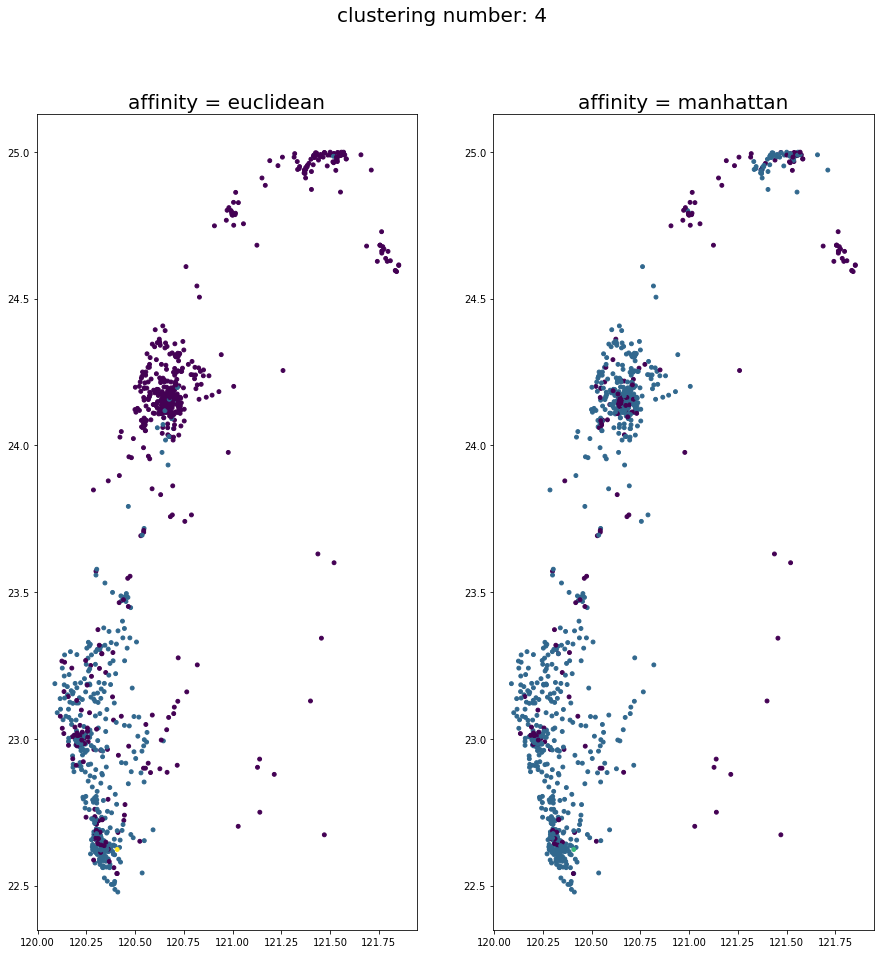

In [14]:
agg_cluster(4)

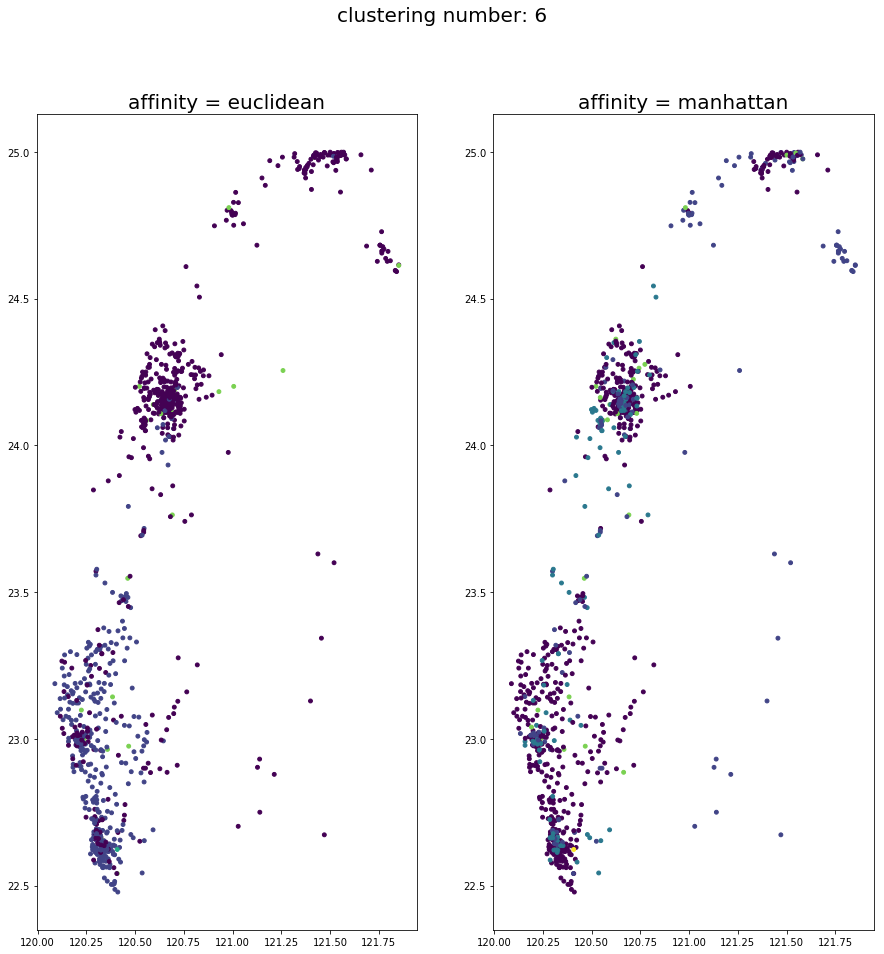

In [15]:
agg_cluster(6)

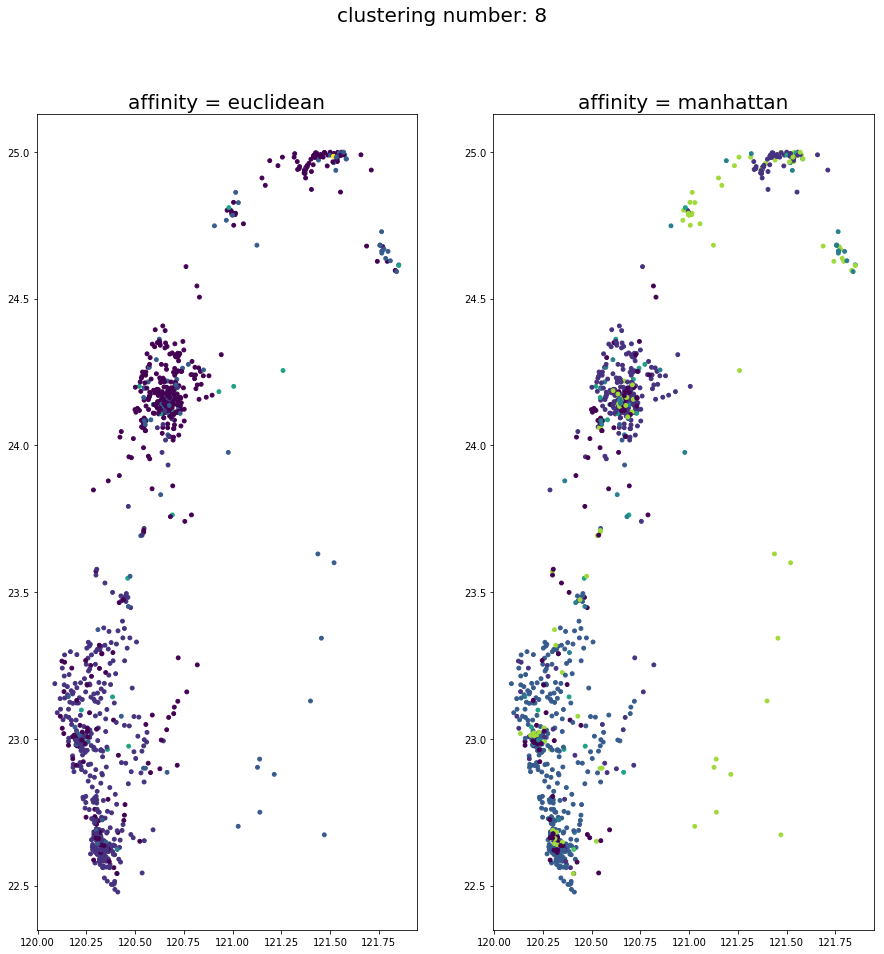

In [16]:
agg_cluster(8)

### Comment
    Silhouette method illustrates that the clustering performance will be the best when K = 4 for agglomerative method. Besides, the Manhattan distance is more appropriate than the Euclidean distance because the feature is the timing flow of PM2.5. So we choose K = 4 with Manhattan distance to plot the result as below.

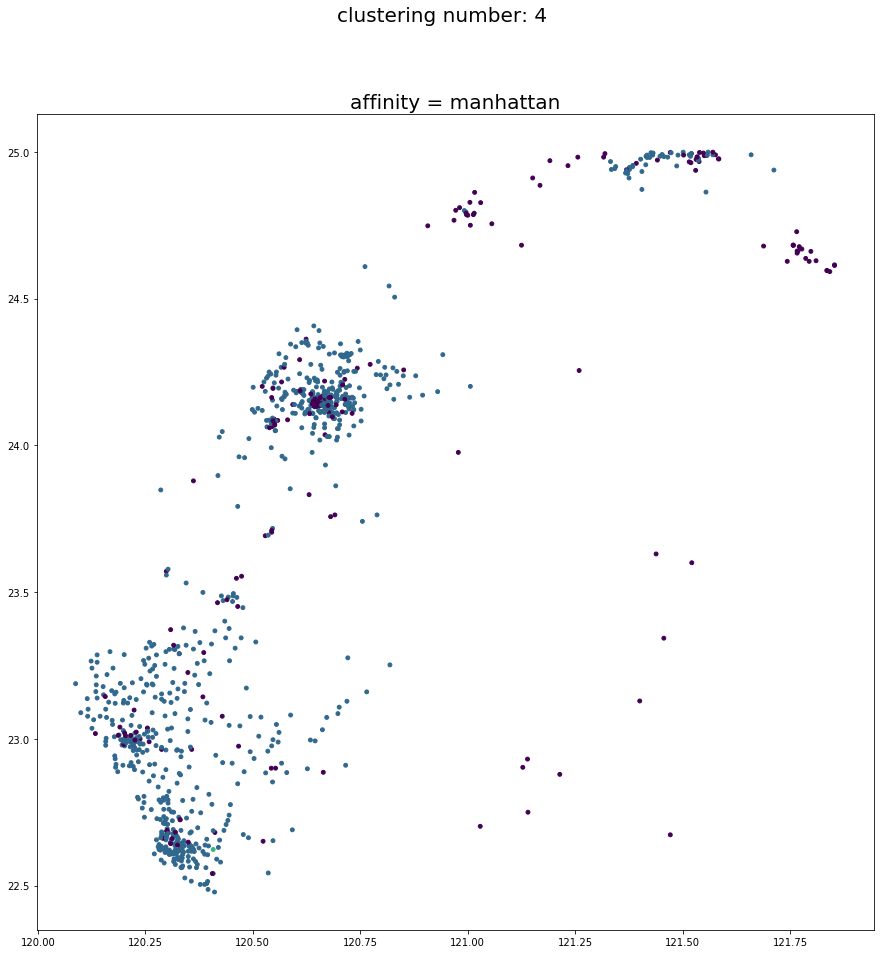

In [17]:
fig = plt.figure(figsize=(15, 15))
metric = 'manhattan'
n_clusters = 4
model = AgglomerativeClustering(n_clusters=n_clusters, affinity=metric, linkage="complete").fit(weekflow)
plt.title("affinity = %s" % metric, size=20)
plt.scatter(x, y, c=model.labels_, s=15, zorder=3)
plt.suptitle("clustering number: %d" % n_clusters, size=20)
plt.show()

## Conclusion
    The KMeans method with cluster number equals to 2 has almost the same result with Agglomerative method with cluster number equals to 4 and the metric equals to Manhattan. It seems that the result shows that the PM2.5 concentration along with time has higher simularity around the location of government-owned thermal power plants showned below.
    I think it is because the concentraion of PM2.5 around the plants will be higher than normal when the the thermal power plants are under operation. Once the thermal power thermal plants are in the state of low loading, then the PM2.5 data will have low concentration during the time. The PM2.5 concentration away from these thermal power plants forms another cluster that has less influence caused by the operation of the thermal power plants.

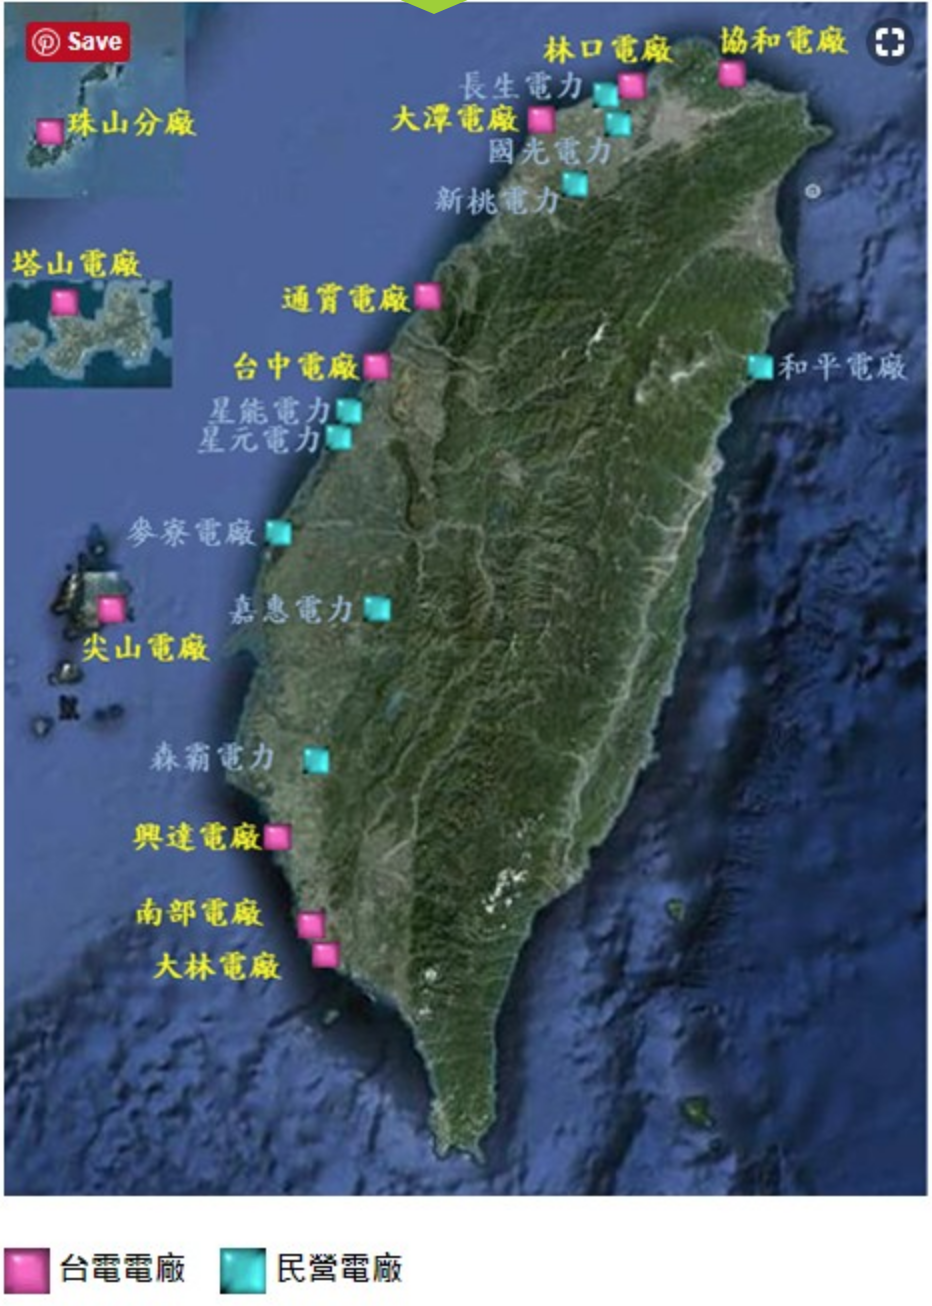

In [18]:
from IPython.display import Image
Image(filename = 'plant.png', width=500, height = 200)